<div>
<img src="https://i.ibb.co/v3CvVz9/udd-short.png" width="150"/>
    <br>
    <strong>Universidad del Desarrollo</strong><br>
    <em>Magíster en Data Science</em><br>
    <em>Visión Computacional </em><br>
    <em>Profesor: Takeshi Asahi </em><br>

</div>

# Machine Learning Avanzado
*22 de Abril de 2024*

#### Integrantes: 
` Giuseppe Lavarello`

## 1. Objetivo

El objetivo principal de esta tarea consiste en implementar una serie de pasos que concluyan en la creación de un modelo de clasificación para el conjunto de datos **Brain Tumor MRI Dataset**, disponible en **Kaggle**.

1. Se eligió este dataset por su relevancia en el tratamiento de pacientes con tumores cerebrales. Este es un problema importante, pues la identificación de los tumores facilita la determinación del tratamiento con mayores probabilidades de éxito.
2. El propósito es identificar los tipos de tumores presentes en las imágenes obtenidas mediante resonancia magnética, entre: tumores pituitarios, gliomas, meningiomas o la ausencia de tumor.
3. Pasos a seguir:
    - Diseñar un flujo de procesamiento: adquisición de imágenes, preprocesamiento, procesamiento de imágenes, cálculo de mediciones y almacenamiento.
    - Implementar un sistema de clasificación mediante CNN.
    - Medir los tiempos de ejecución del procesamiento de las imágenes de prueba.
    - Hacer un resumen de los resultados del procesamiento, en particular de sus métricas.


# 2. Carga de datos

In [2]:


# manejo datos
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
# visualización y gráficos
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
# Os y glob para manejo de archivos
import os
from glob import glob

# Modelos
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, AveragePooling2D

# Configuración de TensorFlow para evitar advertencias y errores de GPU
import warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import logging
import absl.logging
absl.logging.set_verbosity('error')  # or 'fatal'
logging.getLogger('tensorflow').setLevel(logging.ERROR)

#medicion de ejecucion
import time

2025-05-09 16:30:11.153822: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746822611.286019  104193 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746822611.324280  104193 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746822611.642494  104193 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746822611.642524  104193 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746822611.642526  104193 computation_placer.cc:177] computation placer alr

**Decisión**  
En esta tarea, a diferencia de la anterior, se creará un dataframe que contenga el `path` y la `clase` de cada imagen. Esto permitirá realizar el preprocesamiento directamente con la librería `ImageDataGenerator` de Keras.


In [3]:
def load_paths(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])

    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes}) # DataFrame con rutas y etiquetas
    return tr_df

In [4]:
tr_df = load_paths(r'./data/Training')
ts_df = load_paths(r'./data/Testing')


In [5]:
# Visualización de las clases y sus conteos
def plot_class_distribution(df):
    """ Visualiza la distribución de clases en el conjunto de entrenamiento.
    Args:
        tr_df (DataFrame): DataFrame que contiene las rutas de las imágenes y sus etiquetas.
    """

    sns.set_style("whitegrid")

    plt.figure(figsize=(12, 6))

    ax = sns.countplot(data=df, x='Class', order=tr_df['Class'].value_counts().index)

    ax.set_title('Distribución de Clases en el Conjunto de Entrenamiento')
    ax.set_xlabel('Clases')
    ax.set_ylabel('Conteo')
    plt.xticks(rotation=25)


    # añadir cantidad dentro de las barras
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()//2), 
                    ha='center', 
                    va='bottom', 
                    fontsize=15, 
                    color='w', 
                    weight='bold', 
                    rotation=90, 
                    xytext=(0, 5), 
                    textcoords='offset points')
    
    #añadir total de imágenes arriba a la derecha 
    total = len(df)
    ax.annotate(f'Total de imagenes: {total}', 
                (0.9, 0.90), 
                xycoords='axes fraction', 
                ha='right', 
                va='top', 
                fontsize=15, 
                color='black',  
                rotation=0, 
                xytext=(0, 5), 
                textcoords='offset points')
    plt.tight_layout()
    plt.show()

**Decisión**  
Dado que no hay datos de validación, separamos aleatoriamente los datos de prueba en dos grupos: 50% para validación y 50% para prueba.


In [6]:
val_df, ts_df = train_test_split(ts_df, train_size=0.5, random_state=1122, stratify=ts_df['Class'])

En los siguientes diagramas podemos ver que el dataset se compone de 3 grupos: `ts_df`, `val_df` y `tr_df`. Cada uno contiene imágenes de las 4 clases presentes en los datos: `notumor`, `pituitary`, `meningioma` y `glioma`. El conjunto `tr_df` consiste en 5712 imágenes, `ts_df` en 656 imágenes y `val_df` en una cantidad de imágenes no especificada.


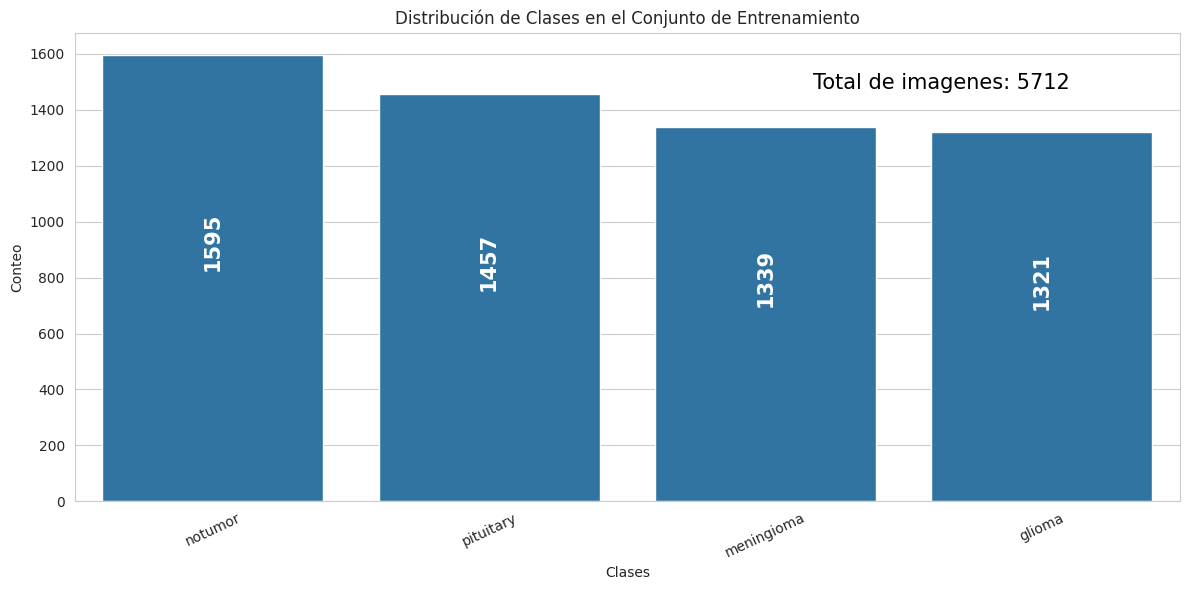

In [7]:
plot_class_distribution(tr_df)

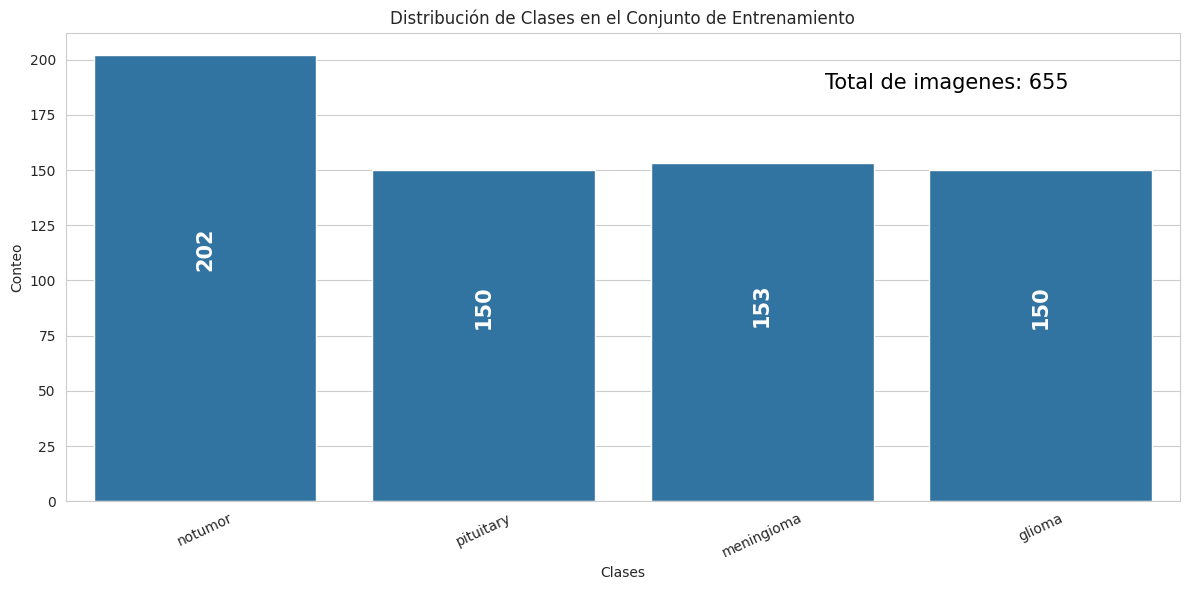

In [8]:
plot_class_distribution(val_df)

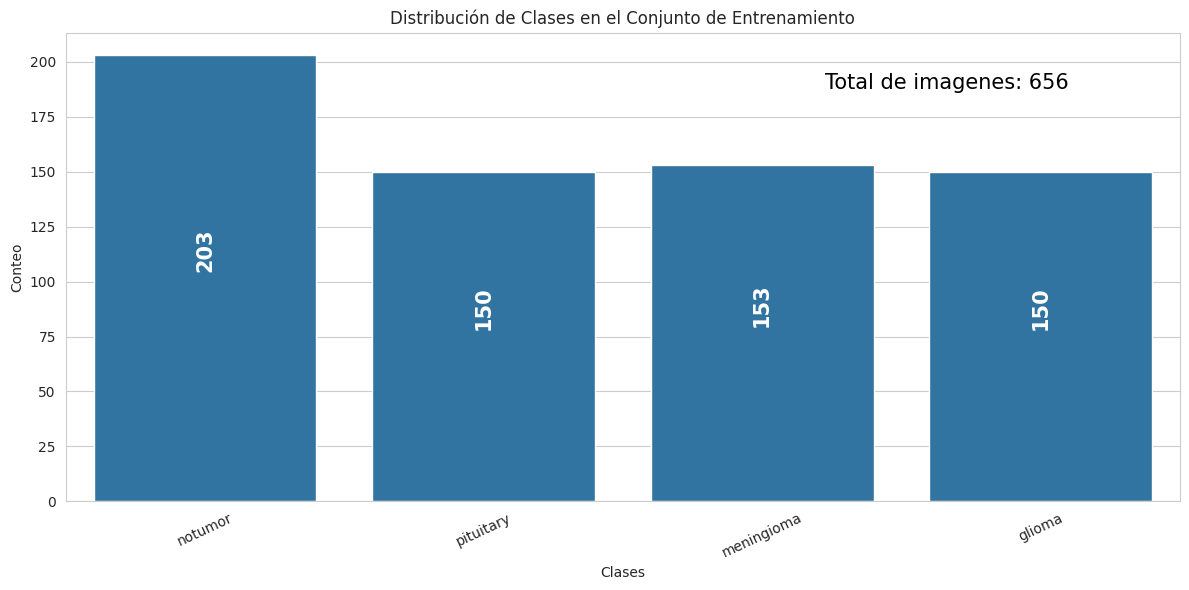

In [9]:
plot_class_distribution(ts_df)

**Importante**  
Aunque existe un pequeño desbalance en los datos a favor de la clase `notumor`, este no es lo suficientemente significativo como para justificar una limpieza más profunda en esta etapa. Sin embargo, en las siguientes iteraciones de esta tarea se trabajará para tratar de obtener mejores resultados.


In [10]:
tr_df.describe()

,Class Path,Class
count,5712,5712
unique,5712,4
top,./data/Training/pituitary/Tr-pi_1440.jpg,notumor
freq,1,1595


In [11]:
val_df.describe()

,Class Path,Class
count,655,655
unique,655,4
top,./data/Testing/pituitary/Te-pi_0297.jpg,notumor
freq,1,202


In [12]:
ts_df.describe()

,Class Path,Class
count,656,656
unique,656,4
top,./data/Testing/meningioma/Te-me_0112.jpg,notumor
freq,1,203


# 3. Preprocesamiento
Se crean los manipuladores de imagen y se realizan tres tratamientos distintos para generar diferentes conjuntos de datos. 

1. En la primera iteración, las imágenes son reescaladas y convertidas a escala de grises.



In [13]:

batch_size = 32
img_size = (256, 256)

_gen = ImageDataGenerator(rescale=1/255)

ts_gen = ImageDataGenerator(rescale=1/255)


tr_gen = _gen.flow_from_dataframe(tr_df, x_col='Class Path',
                                    y_col='Class', batch_size=batch_size,
                                    target_size=img_size, # reescalado de imagenes
                                    color_mode='grayscale', # cambio a greyscale

                                  )

valid_gen = _gen.flow_from_dataframe(val_df, x_col='Class Path',
                                        y_col='Class', batch_size=batch_size,
                                        target_size=img_size, # reescalado de imagenes)
                                        color_mode='grayscale', # cambio a greyscale

                                     )

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col='Class Path',
                                    y_col='Class', batch_size=16,
                                    target_size=img_size, # reescalado de imagenes)
                                    color_mode='grayscale', # cambio a greyscale
                                    shuffle=False)




Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


2. En la segunda iteración, las imágenes son rotadas aleatoriamente entre 0 y 90 grados.


In [14]:
_gen_rotated = ImageDataGenerator(rescale=1/255, rotation_range=90)

tr_gen_rotated = _gen_rotated.flow_from_dataframe(tr_df, x_col='Class Path',
                                    y_col='Class', batch_size=batch_size,
                                    target_size=img_size, # reescalado de imagenes
                                    color_mode='grayscale', # cambio a greyscale
                                    class_mode='categorical', # clasificacion multiclase
                                  )

valid_gen_rotated = _gen_rotated.flow_from_dataframe(val_df, x_col='Class Path',
                                        y_col='Class', batch_size=batch_size,
                                        target_size=img_size, # reescalado de imagenes)
                                        color_mode='grayscale', # cambio a greyscale
                                        class_mode='categorical', # clasificacion multiclase
                                     )

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.


3. En la tercera iteración, las imágenes son rotadas aleatoriamente entre 0 y 90 grados, y trasladadas también de forma aleatoria hasta un 20% tanto en alto como en ancho.


In [15]:
_gen_rotated_shifted = ImageDataGenerator(rescale=1/255, rotation_range=90,width_shift_range=0.2, height_shift_range=0.2)

tr_gen_rotated_shifted = _gen_rotated_shifted.flow_from_dataframe(tr_df, x_col='Class Path',
                                    y_col='Class', batch_size=batch_size,
                                    target_size=img_size, # reescalado de imagenes
                                    color_mode='grayscale', # cambio a greyscale
                                    class_mode='categorical', # clasificacion multiclase
                                  )

valid_gen_rotated_shifted = _gen_rotated_shifted.flow_from_dataframe(val_df, x_col='Class Path',
                                        y_col='Class', batch_size=batch_size,
                                        target_size=img_size, # reescalado de imagenes)
                                        color_mode='grayscale', # cambio a greyscale
                                        class_mode='categorical', # clasificacion multiclase
                                     )

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.


## 3.1 Muestra de imagenes

1. Las imagenes se presentan con buen contraste y escala. Es importante notar que el corte de la imagen esta en diferentes orientaciones, lo que puede confundir al modelo.

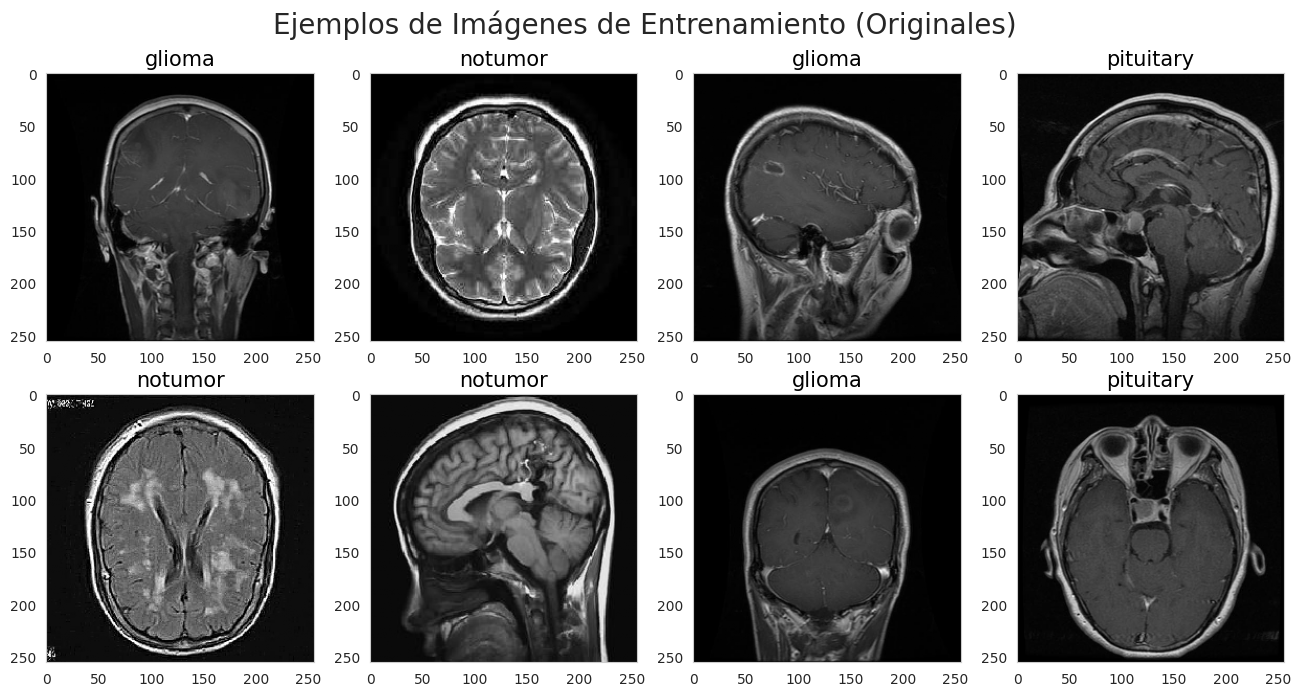

In [16]:

classes = list(tr_gen.class_indices.keys())
images, labels = next(tr_gen)

def plot_images(images, labels, classes, title):
    plt.figure(figsize=(16, 16))
    plt.suptitle(title, fontsize=20, y=0.92)
    for i, (image, label) in enumerate(zip(images, labels)):
        if i >= 8:
            break
        plt.subplot(4,4, i + 1)
        plt.imshow(image, cmap='gray')
        class_name = classes[np.argmax(label)]
        plt.title(class_name, color='k', fontsize=15)
        plt.grid(False)

    plt.show()
plot_images(images, labels, classes, title='Ejemplos de Imágenes de Entrenamiento (Originales)')


2. Las imágenes rotadas ayudan a generalizar el modelo. En este caso en particular, dado que los cortes pueden presentarse en diferentes orientaciones, es probable que esto también confunda al modelo.


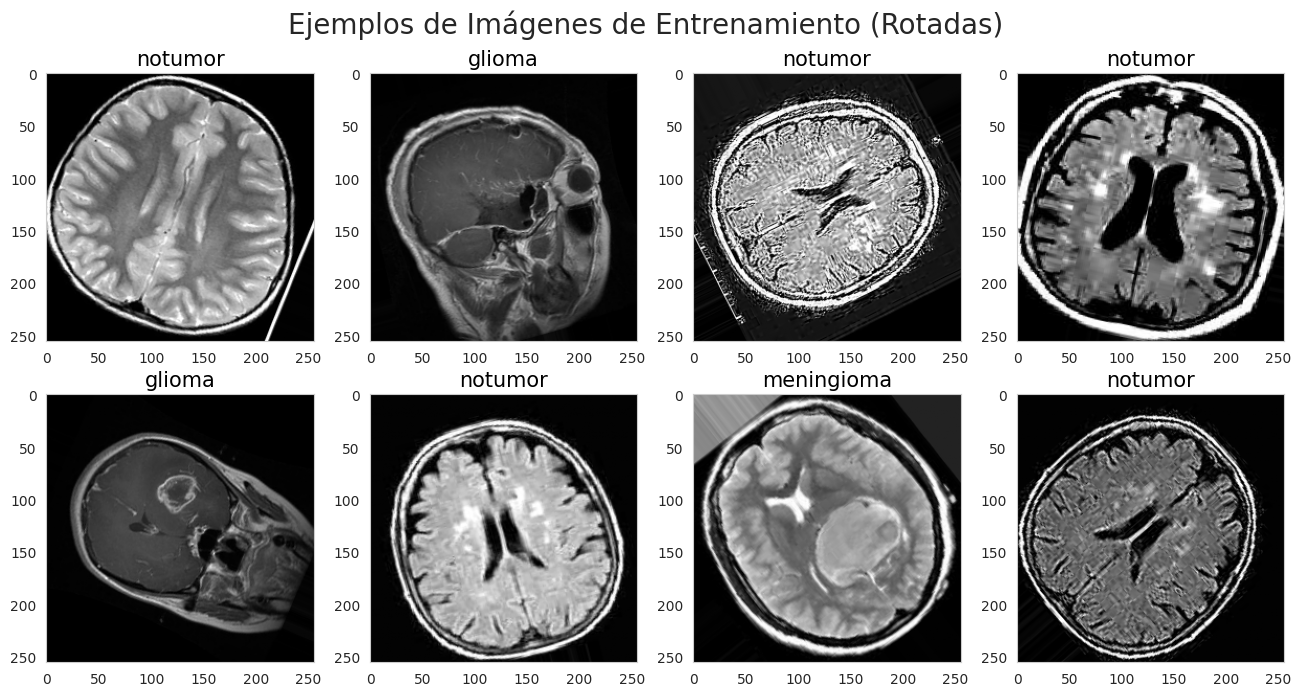

In [17]:
images, labels = next(tr_gen_rotated)
plot_images(images, labels, classes, title='Ejemplos de Imágenes de Entrenamiento (Rotadas)')

3. En este caso, las imágenes se presentan trasladadas además de rotadas. Se puede notar rápidamente que se pierde información y, en algunos casos, se generan artefactos. Es altamente probable que esto disminuya la utilidad final del modelo.


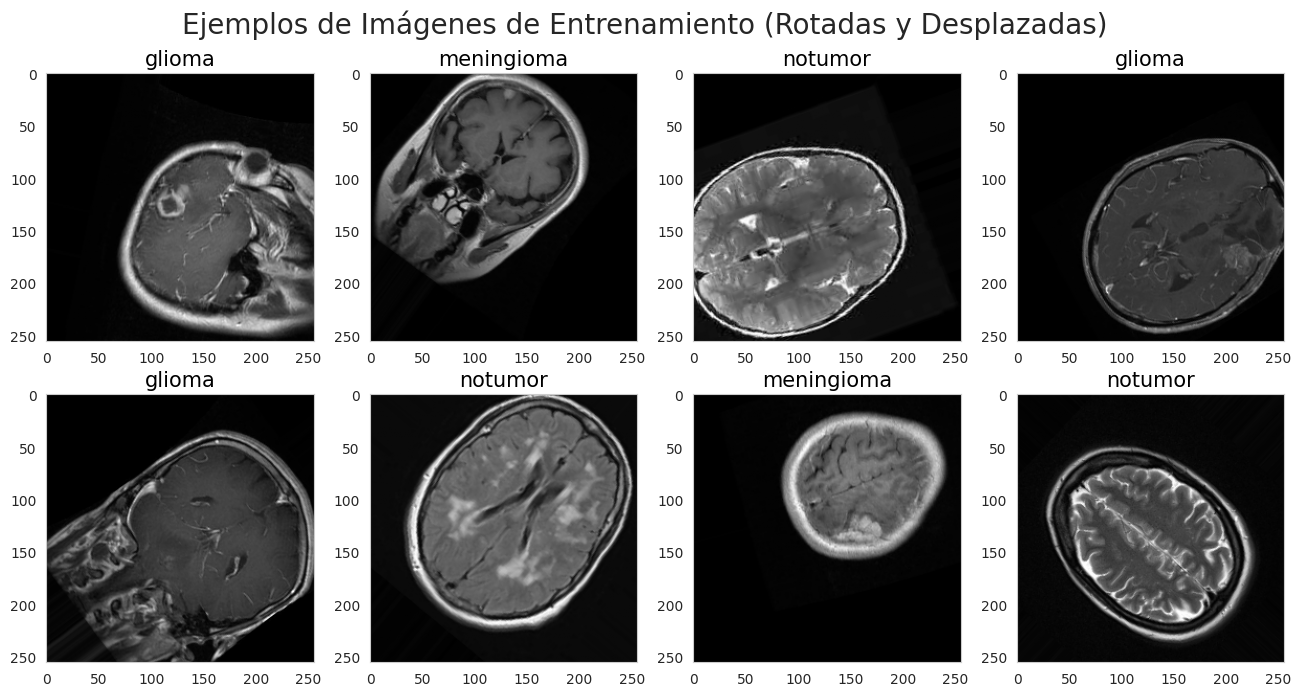

In [18]:
images, labels = next(tr_gen_rotated_shifted)
plot_images(images, labels, classes, title='Ejemplos de Imágenes de Entrenamiento (Rotadas y Desplazadas)')

Se crean los modelos. Su arquitectura se puede ver mejor en la siguiente imagen: ![Arquitectura del Modelo](model.png)


In [19]:
# Definición del modelo

epocas = 10
img_shape=(256,256,1)
  
model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 3),activation='relu', input_shape=(256,256,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Conv2D(128, kernel_size=(3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Conv2D(256, kernel_size=(3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())    
    
model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])

model.summary()




I0000 00:00:1746822646.120793  104193 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9711 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 230400)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    58,982,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,395,524 (226.58 MB)

 Trainable params: 59,394,628 (226.57 MB)

 Non-trainable params: 896 (3.50 KB)

Cada modelo se entrena antes de crear el siguiente.


In [20]:

hist = model.fit(tr_gen,
                     epochs=epocas,
                     validation_data=valid_gen,
                     shuffle= False)




Epoch 1/10


I0000 00:00:1746822650.731965  105409 service.cc:152] XLA service 0x7f5038016d40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746822650.732003  105409 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-05-09 16:30:50.861694: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746822651.182158  105409 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-09 16:30:52.563551: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1454', 32 bytes spill stores, 32 bytes spill loads

2025-05-09 16:30:53.040597: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1022'

  1/179 ━━━━━━━━━━━━━━━━━━━━ 50:40 17s/step - accuracy: 0.2812 - loss: 3.4071 - precision: 0.2903 - recall: 0.2812

I0000 00:00:1746822664.962760  105409 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


179/179 ━━━━━━━━━━━━━━━━━━━━ 56s 218ms/step - accuracy: 0.6636 - loss: 5.5098 - precision: 0.6646 - recall: 0.6611 - val_accuracy: 0.1664 - val_loss: 29.4553 - val_precision: 0.1664 - val_recall: 0.1664
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 24s 131ms/step - accuracy: 0.8536 - loss: 0.6763 - precision: 0.8572 - recall: 0.8529 - val_accuracy: 0.4092 - val_loss: 4.7483 - val_precision: 0.4253 - val_recall: 0.4000
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 22s 124ms/step - accuracy: 0.8971 - loss: 0.3891 - precision: 0.8986 - recall: 0.8957 - val_accuracy: 0.6565 - val_loss: 1.8184 - val_precision: 0.6683 - val_recall: 0.6336
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 22s 123ms/step - accuracy: 0.9377 - loss: 0.1895 - precision: 0.9380 - recall: 0.9373 - val_accuracy: 0.8885 - val_loss: 0.3749 - val_precision: 0.8911 - val_recall: 0.8870
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 22s 125ms/step - accuracy: 0.9563 - loss: 0.1176 - precision: 0.9574 - recall: 0.9558 - val_accuracy: 0.9115 - val_los

In [21]:
def plot_training_history(hist):
    """ Visualiza la historia de entrenamiento del modelo.
    Args:
        hist (History): Historia de entrenamiento del modelo.
    """
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    tr_per = hist.history['precision']
    tr_recall = hist.history['recall']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    val_per = hist.history['val_precision']
    val_recall = hist.history['val_recall']

    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    index_precision = np.argmax(val_per)
    per_highest = val_per[index_precision]
    index_recall = np.argmax(val_recall)
    recall_highest = val_recall[index_recall]

    Epochs = [i + 1 for i in range(len(tr_acc))]
    loss_label = f'Best epoch = {str(index_loss + 1)}'
    acc_label = f'Best epoch = {str(index_acc + 1)}'
    per_label = f'Best epoch = {str(index_precision + 1)}'
    recall_label = f'Best epoch = {str(index_recall + 1)}'


    plt.figure(figsize=(20, 12))
    plt.style.use('fivethirtyeight')


    plt.subplot(2, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label='Training loss')
    plt.plot(Epochs, val_loss, 'g', label='Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label, zorder=2)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
    plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label, zorder=2)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.yticks(np.arange(0, 1.1, 0.1), [f'{int(i*100)}%' for i in np.arange(0, 1.1, 0.1)])
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 2, 3)
    plt.plot(Epochs, tr_per, 'r', label='Precision')
    plt.plot(Epochs, val_per, 'g', label='Validation Precision')
    plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label, zorder=2)
    plt.title('Precision and Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.yticks(np.arange(0, 1.1, 0.1), [f'{int(i*100)}%' for i in np.arange(0, 1.1, 0.1)])
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 2, 4)
    plt.plot(Epochs, tr_recall, 'r', label='Recall')
    plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
    plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label, zorder=2)
    plt.title('Recall and Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    #make yticks percentage
    plt.yticks(np.arange(0, 1.1, 0.1), [f'{int(i*100)}%' for i in np.arange(0, 1.1, 0.1)])
    plt.legend()
    plt.grid(True)

    plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
    plt.show()

El modelo original se estabiliza rápidamente, obteniendo pequeñas ganancias después de la cuarta iteración.


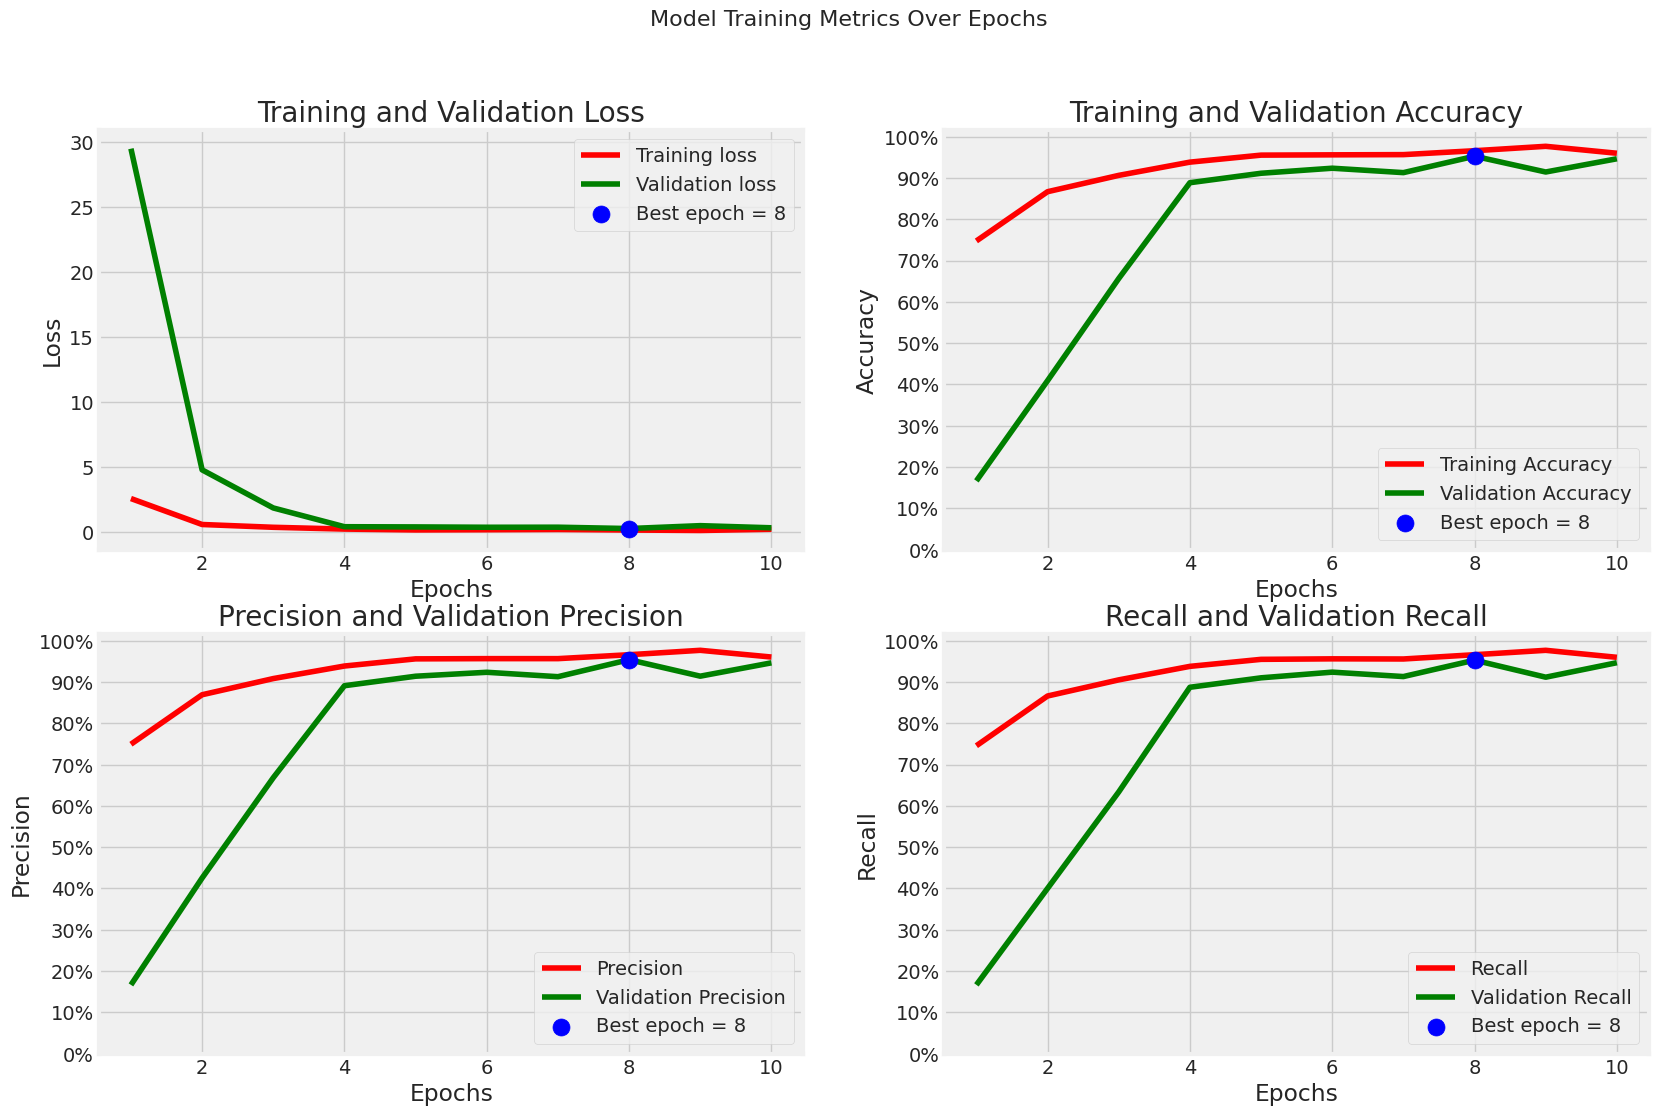

In [22]:
plot_training_history(hist)

Se crea el segundo modelo para las imágenes rotadas, utilizando la misma arquitectura que el modelo original.


In [23]:
model_rotated = Sequential()

model_rotated.add(Conv2D(64, kernel_size=(3, 3),activation='relu', input_shape=(256,256,1)))
model_rotated.add(BatchNormalization())
model_rotated.add(MaxPooling2D())

model_rotated.add(Conv2D(128, kernel_size=(3, 3),activation='relu'))
model_rotated.add(BatchNormalization())
model_rotated.add(MaxPooling2D())

model_rotated.add(Conv2D(256, kernel_size=(3, 3),activation='relu'))
model_rotated.add(BatchNormalization())
model_rotated.add(MaxPooling2D())    
    
model_rotated.add(Flatten())

model_rotated.add(Dense(256, activation='relu'))
model_rotated.add(Dense(128, activation='relu'))
model_rotated.add(Dense(64, activation='relu'))
model_rotated.add(Dense(4, activation='softmax'))

model_rotated.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])

model_rotated.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 254, 254, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 254, 254, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 127, 127, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 125, 125, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 125, 125, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 60, 60, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 60, 60, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 230400)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │    58,982,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,395,524 (226.58 MB)

 Trainable params: 59,394,628 (226.57 MB)

 Non-trainable params: 896 (3.50 KB)

In [24]:

hist_rotated = model.fit(tr_gen_rotated,
                     epochs=epocas,
                     validation_data=valid_gen_rotated,
                     shuffle= False)


Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 38s 212ms/step - accuracy: 0.7168 - loss: 1.3845 - precision: 0.7239 - recall: 0.7111 - val_accuracy: 0.7588 - val_loss: 0.8663 - val_precision: 0.7672 - val_recall: 0.7496
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 40s 221ms/step - accuracy: 0.8010 - loss: 0.6607 - precision: 0.8084 - recall: 0.7912 - val_accuracy: 0.8107 - val_loss: 0.5111 - val_precision: 0.8212 - val_recall: 0.7924
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 40s 223ms/step - accuracy: 0.8487 - loss: 0.4549 - precision: 0.8590 - recall: 0.8421 - val_accuracy: 0.7695 - val_loss: 0.9427 - val_precision: 0.7723 - val_recall: 0.7664
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 38s 209ms/step - accuracy: 0.8547 - loss: 0.4561 - precision: 0.8612 - recall: 0.8498 - val_accuracy: 0.7847 - val_loss: 0.5855 - val_precision: 0.7913 - val_recall: 0.7817
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 40s 221ms/step - accuracy: 0.8829 - loss: 0.3791 - precision: 0.8881 - recall: 0.8773 - val_accuracy: 0.7878

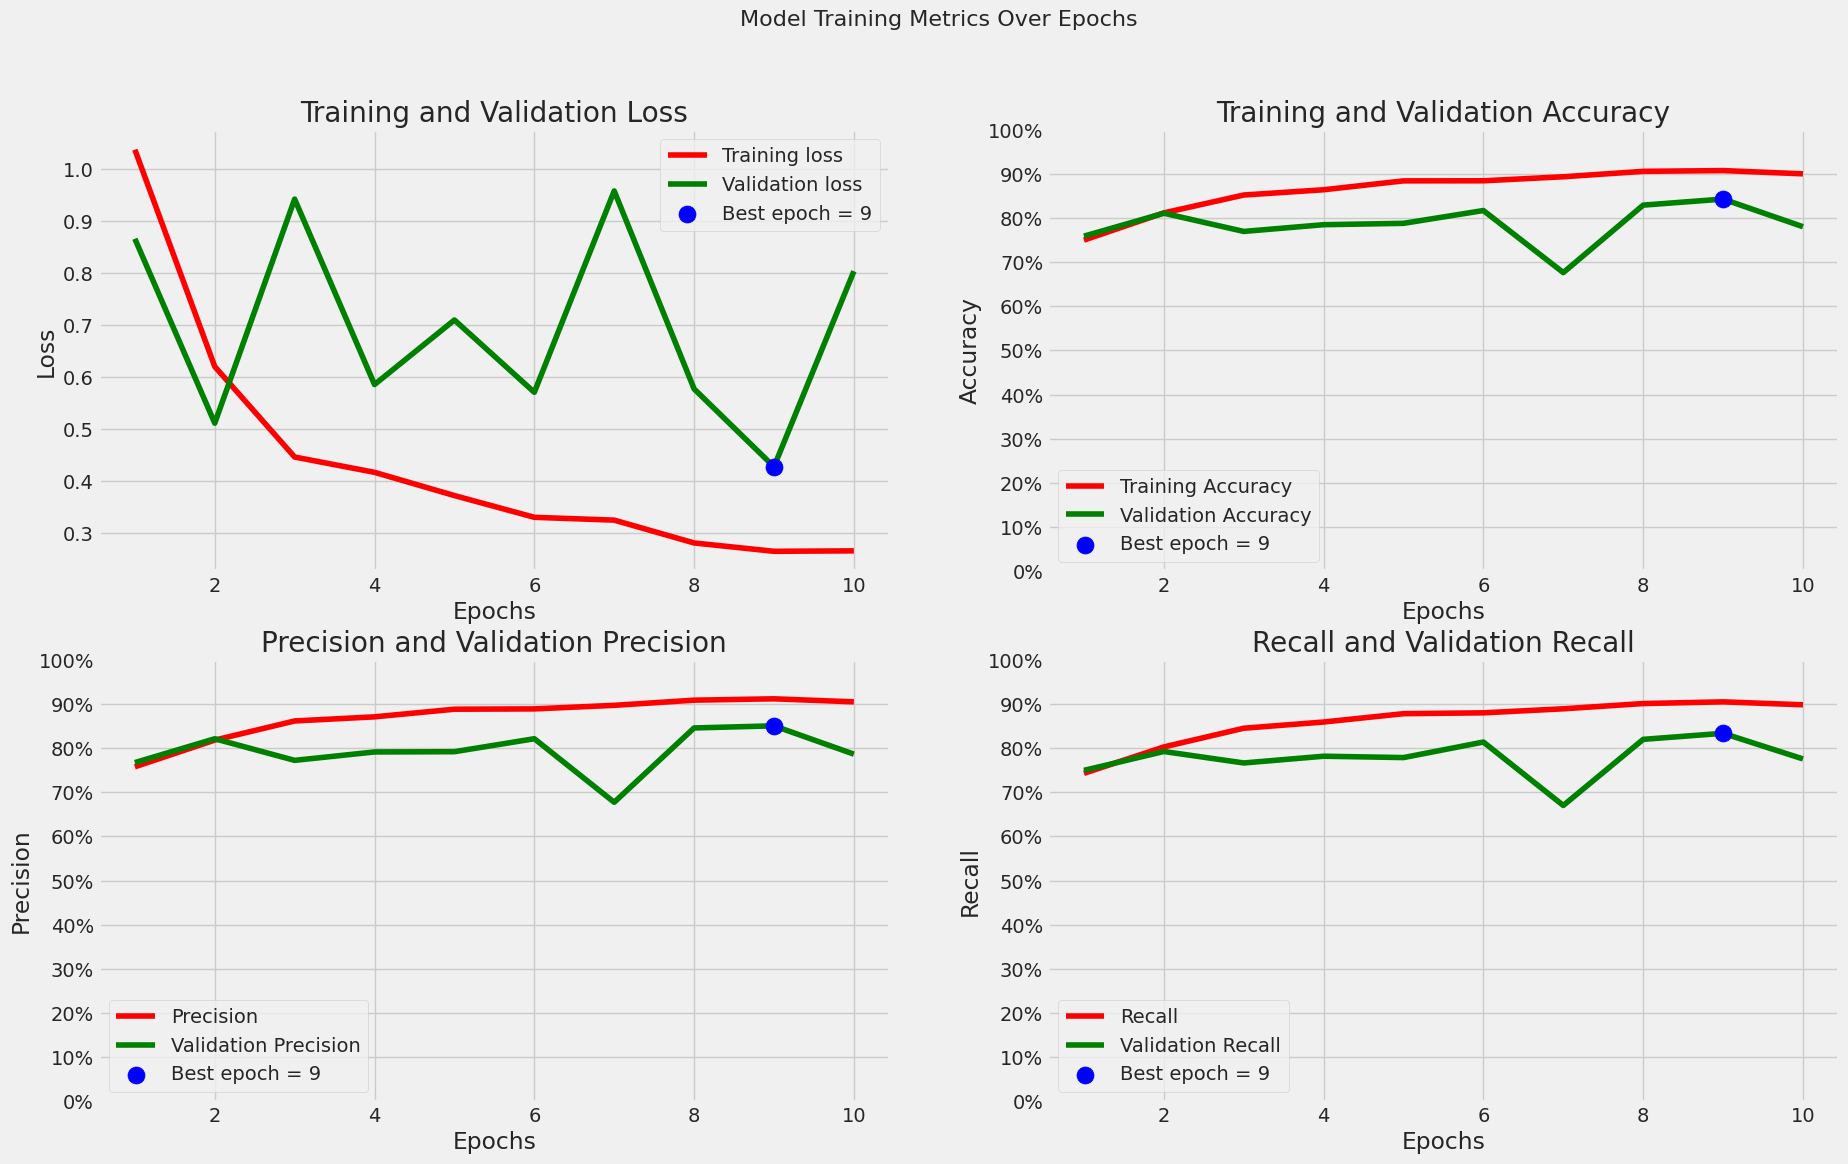

In [25]:
plot_training_history(hist_rotated)

En este caso, si bien el modelo muestra una tendencia clara de mejora, es fácil ver que la validación no acompaña al entrenamiento y eventualmente diverge. En una iteración futura, podría aumentarse el número de épocas y observar cómo evoluciona.




In [26]:
model_rotated_shifted = Sequential()

model_rotated_shifted.add(Conv2D(64, kernel_size=(3, 3),activation='relu', input_shape=(256,256,1)))
model_rotated_shifted.add(BatchNormalization())
model_rotated_shifted.add(MaxPooling2D())

model_rotated_shifted.add(Conv2D(128, kernel_size=(3, 3),activation='relu'))
model_rotated_shifted.add(BatchNormalization())
model_rotated_shifted.add(MaxPooling2D())

model_rotated_shifted.add(Conv2D(256, kernel_size=(3, 3),activation='relu'))
model_rotated_shifted.add(BatchNormalization())
model_rotated_shifted.add(MaxPooling2D())    
    
model_rotated_shifted.add(Flatten())

model_rotated_shifted.add(Dense(256, activation='relu'))
model_rotated_shifted.add(Dense(128, activation='relu'))
model_rotated_shifted.add(Dense(64, activation='relu'))
model_rotated_shifted.add(Dense(4, activation='softmax'))

model_rotated_shifted.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])

model_rotated_shifted.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 254, 254, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 254, 254, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 127, 127, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 125, 125, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 125, 125, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 62, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 60, 60, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 60, 60, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 230400)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │    58,982,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,395,524 (226.58 MB)

 Trainable params: 59,394,628 (226.57 MB)

 Non-trainable params: 896 (3.50 KB)

In [27]:
hist_rotated_shifted = model.fit(tr_gen_rotated_shifted,
                     epochs=epocas,
                     validation_data=valid_gen_rotated_shifted,
                     shuffle= False)

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 41s 225ms/step - accuracy: 0.7326 - loss: 0.9172 - precision: 0.7539 - recall: 0.7089 - val_accuracy: 0.6015 - val_loss: 1.0977 - val_precision: 0.6182 - val_recall: 0.5908
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 41s 225ms/step - accuracy: 0.8145 - loss: 0.5517 - precision: 0.8323 - recall: 0.7867 - val_accuracy: 0.7649 - val_loss: 0.7440 - val_precision: 0.7755 - val_recall: 0.7542
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 38s 213ms/step - accuracy: 0.8364 - loss: 0.4543 - precision: 0.8502 - recall: 0.8213 - val_accuracy: 0.4870 - val_loss: 1.7768 - val_precision: 0.4891 - val_recall: 0.4779
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 40s 221ms/step - accuracy: 0.8358 - loss: 0.4918 - precision: 0.8507 - recall: 0.8208 - val_accuracy: 0.6351 - val_loss: 1.6044 - val_precision: 0.6539 - val_recall: 0.6260
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 42s 231ms/step - accuracy: 0.8560 - loss: 0.3970 - precision: 0.8692 - recall: 0.8451 - val_accuracy: 0.5710

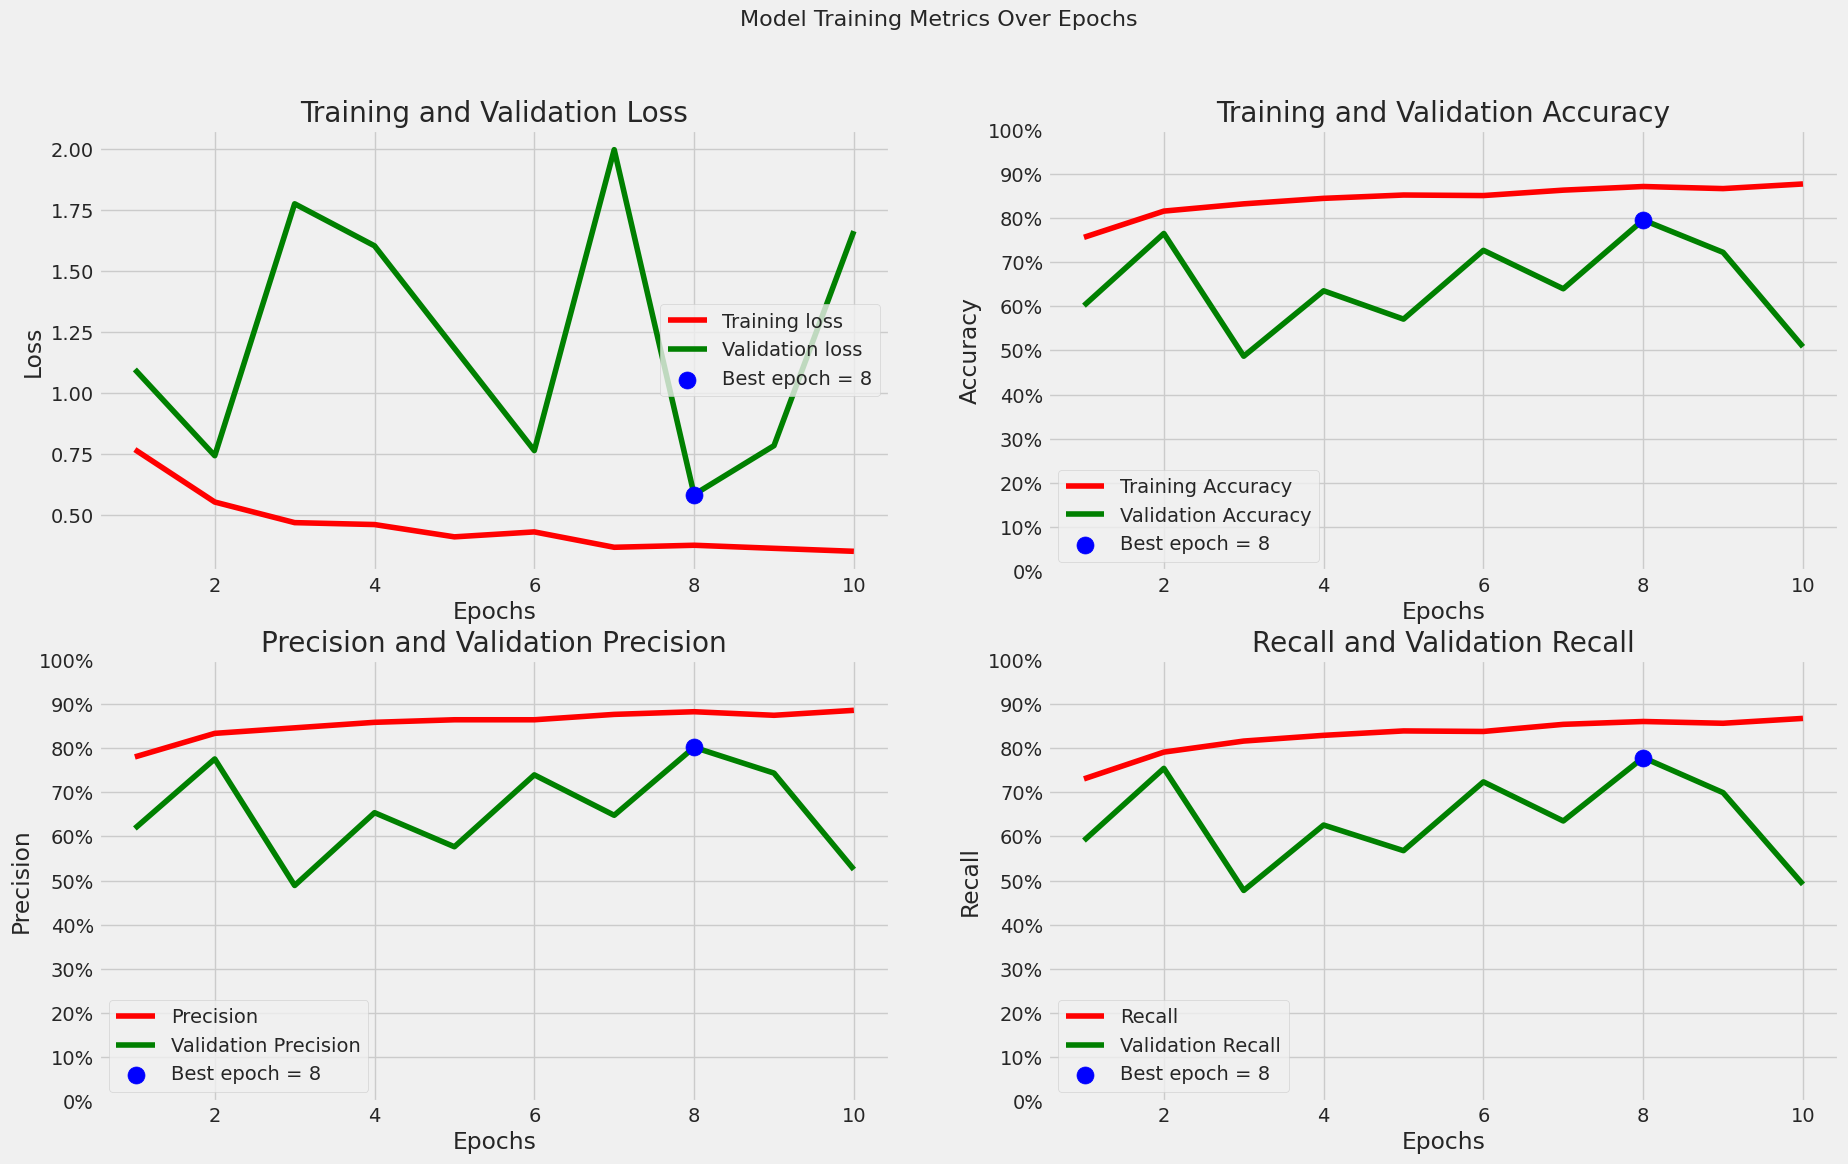

In [28]:
plot_training_history(hist_rotated_shifted)

En este caso, la validación oscila con una amplitud incluso mayor que en el caso anterior, lo que permite deducir que hay una alta probabilidad de que esto haya confundido al modelo.


# 4. Tiempo de Procesamiento


Una vez entrenados los modelos, medimos el tiempo de procesamiento del conjunto de prueba en cada uno y, finalmente, obtenemos la matriz de confusión de cada modelo.


## 4.1 Todas las imagenes

In [29]:
repeticiones = 10
tiempo = []
for i in range(repeticiones):
    start_time = time.time()
    pred = model.predict(ts_gen)
    end_time = time.time()
    tiempo.append({"tiempo" :end_time - start_time})

df_tiempo = pd.DataFrame(tiempo)

y_pred = np.argmax(pred, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step


In [30]:
tiempo_rotado = []
for i in range(repeticiones):
    start_time = time.time()
    pred_rotado = model_rotated.predict(ts_gen)
    end_time = time.time()
    tiempo_rotado.append({"tiempo_rotado" :end_time - start_time})

df_tiempo_rotado = pd.DataFrame(tiempo_rotado)

y_pred_rotado = np.argmax(pred_rotado, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ -0s -7352us/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step


In [31]:
tiempo_rotado_shifted = []
for i in range(repeticiones):
    start_time = time.time()
    pred_rotado_shifted = model_rotated_shifted.predict(ts_gen)
    end_time = time.time()
    tiempo_rotado_shifted.append({"tiempo_rotado_shifted" :end_time - start_time})

df_tiempo_rotado_shifted = pd.DataFrame(tiempo_rotado_shifted)

y_pred_rotado_shifted = np.argmax(pred_rotado_shifted, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ -0s -7415us/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step


In [32]:
df_tiempo_final = df_tiempo.join(df_tiempo_rotado, how='outer').join(df_tiempo_rotado_shifted, how='outer')
df_tiempo_final.head(10)

,tiempo,tiempo_rotado,tiempo_rotado_shifted
0,4.564984,3.525734,3.074114
1,2.363519,3.050684,2.638119
2,2.425645,2.814329,2.554409
3,2.657484,2.677842,2.497915
4,0.326996,2.731140,2.782843
5,2.666649,-0.057759,2.599308
6,2.662178,2.711361,2.455373
7,2.730029,2.481269,2.475123
8,2.507836,2.543373,-0.059837
9,2.531829,2.404639,2.462711


## 4.2 Mitad de las Imagenes 

In [33]:
total_muestras=len(ts_gen.filenames) # total de imagenes en el generador de test
steps= int((total_muestras/ts_gen.batch_size)//2) # pasos por epoca

In [34]:
tiempo_mitad = []
for i in range(repeticiones):
    start_time = time.time()
    pred_mitad = model_rotated.predict(ts_gen, steps=steps) # prediccion con el modelo rotado y desplazado
    end_time = time.time()
    tiempo_mitad.append({"tiempo_mitad" :end_time - start_time})

df_tiempo_mitad = pd.DataFrame(tiempo_mitad)

y_pred_mitad = np.argmax(pred_mitad, axis=1)

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step


In [35]:
tiempo_mitad_rotado = []
for i in range(repeticiones):
    start_time = time.time()
    pred_mitad_rotado = model_rotated.predict(ts_gen, steps=steps) # prediccion con el modelo rotado y desplazado
    end_time = time.time()
    tiempo_mitad_rotado.append({"tiempo_mitad_rotado" :end_time - start_time})

df_tiempo_mitad_rotado = pd.DataFrame(tiempo_mitad_rotado)

y_pred_mitad_rotado = np.argmax(pred_mitad_rotado, axis=1)

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


In [36]:
tiempo_mitad_rotado_shifted = []
for i in range(repeticiones):
    start_time = time.time()
    pred_mitad_rotado_shifted = model_rotated.predict(ts_gen, steps=steps) # prediccion con el modelo rotado y desplazado
    end_time = time.time()
    tiempo_mitad_rotado_shifted.append({"tiempo_mitad_rotado_shifted" :end_time - start_time})

df_tiempo_mitad_rotado_shifted = pd.DataFrame(tiempo_mitad_rotado_shifted)

y_pred_mitad_rotado_shifted = np.argmax(pred_mitad_rotado_shifted, axis=1)

20/20 ━━━━━━━━━━━━━━━━━━━━ -1s -78670us/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


In [37]:
# Se crea el dataframe final con los tiempos de cada modelo
df_tiempo_mitad_final = df_tiempo_mitad.join(df_tiempo_mitad_rotado, how='outer').join(df_tiempo_mitad_rotado_shifted, how='outer')
df_tiempo_final = df_tiempo_final.join(df_tiempo_mitad_final, how='outer')
df_tiempo_final.head(10)

,tiempo,tiempo_rotado,tiempo_rotado_shifted,tiempo_mitad,tiempo_mitad_rotado,tiempo_mitad_rotado_shifted
0,4.564984,3.525734,3.074114,1.402002,1.394485,-1.179178
1,2.363519,3.050684,2.638119,1.271812,1.359776,1.361844
2,2.425645,2.814329,2.554409,1.306114,1.325670,1.329746
3,2.657484,2.677842,2.497915,1.343416,1.333153,1.348780
4,0.326996,2.731140,2.782843,1.370009,1.365739,1.394952
5,2.666649,-0.057759,2.599308,1.318433,1.346942,1.251493
6,2.662178,2.711361,2.455373,1.324554,1.320974,1.374988
7,2.730029,2.481269,2.475123,1.473234,1.367907,1.398320
8,2.507836,2.543373,-0.059837,1.279907,1.350695,1.311628
9,2.531829,2.404639,2.462711,1.348334,1.395873,1.422605


In [38]:
# Obtenemos las medidas estadisticas de los tiempos de cada modelo 
df_tiempo_final.describe()

,tiempo,tiempo_rotado,tiempo_rotado_shifted,tiempo_mitad,tiempo_mitad_rotado,tiempo_mitad_rotado_shifted
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,2.543715,2.488261,2.348008,1.343782,1.356121,1.101518
std,1.006866,0.950789,0.867132,0.060136,0.026035,0.802862
min,0.326996,-0.057759,-0.059837,1.271812,1.320974,-1.179178
25%,2.446193,2.496795,2.465814,1.309194,1.336600,1.316157
50%,2.594656,2.694601,2.526162,1.333985,1.355235,1.355312
75%,2.665532,2.793532,2.628416,1.364591,1.367365,1.389961
max,4.564984,3.525734,3.074114,1.473234,1.395873,1.422605


Finalmente, se obtienen los resultados estadísticos del tiempo de procesamiento, donde se puede observar que, si bien la media varía, existe una relación directa entre el tiempo y la cantidad de imágenes procesadas.  
También se puede ver que debe existir algún tipo de error en la medición, dado que hay casos donde el tiempo medido es negativo.
Es posible que esto sea debido al uso de GPU con tensorflow, en futuras iteraciones se buscara una manera diferente de medir el tiempo corrido.


# 5. Resultados del procesamiento

## 5.1 Modelo Original

El modelo presenta un buen rendimiento en las clases `glioma` y `pituitary`, sin embargo, se confunde ligeramente con la clase `notumor` y `meningioma`. Es posible que, al ajustar los hiperparámetros, se logre mejorar el rendimiento del modelo en futuras iteraciones.


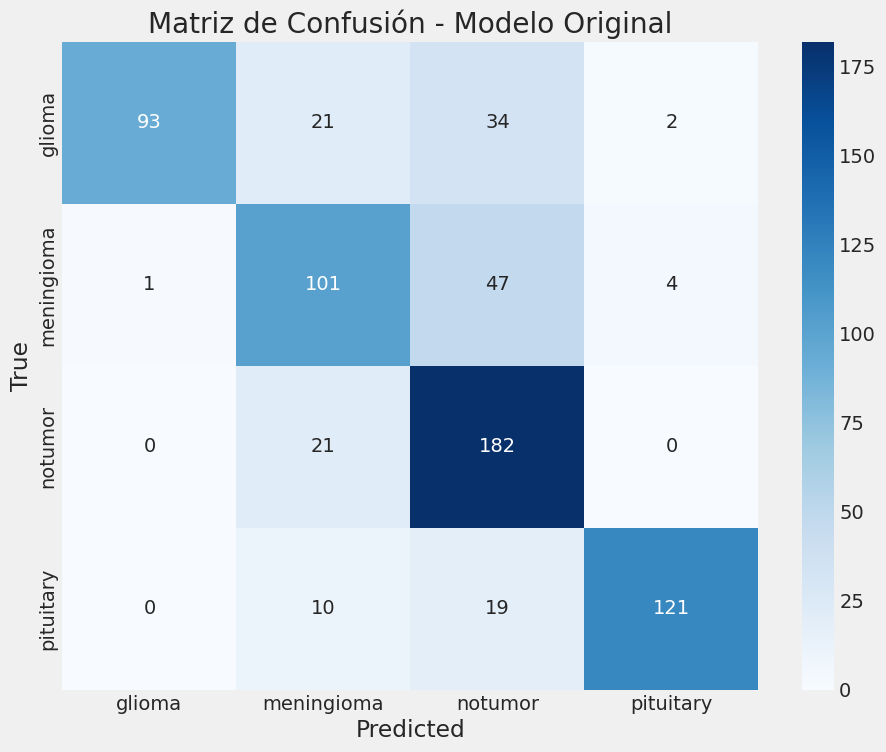

In [39]:

def confusion_matrix_plot(y_predicho, title='Confusion Matrix'):
    cm = confusion_matrix(ts_gen.classes, y_predicho)
    clases= list(ts_gen.class_indices.keys())
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=clases, yticklabels=clases)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()
    

confusion_matrix_plot(y_pred, title='Matriz de Confusión - Modelo Original')





In [40]:
from sklearn.metrics import classification_report

print(classification_report(ts_gen.classes, y_pred, target_names=ts_gen.class_indices.keys()))


              precision    recall  f1-score   support

      glioma       0.99      0.62      0.76       150
  meningioma       0.66      0.66      0.66       153
     notumor       0.65      0.90      0.75       203
   pituitary       0.95      0.81      0.87       150

    accuracy                           0.76       656
   macro avg       0.81      0.75      0.76       656
weighted avg       0.80      0.76      0.76       656



El modelo se presenta bastante robusto para la mayoria de los casos pero esta fundamentalmente atrofiado para el analisis medicinal, más rondas de preprocesamiento y tuneo de hiperparametros sera necesario antes de que pueda cumplir con su funcionamiento. 

## 5.2 Modelo Rotado

En este caso, a diferencia del anterior el modelo se vio completamente encandilado con la clase `pitituary`, asignando casi todas las imagenes a esta clase, lo cual muestra una clara deficiencia de el preprocesamiento de imagenes.

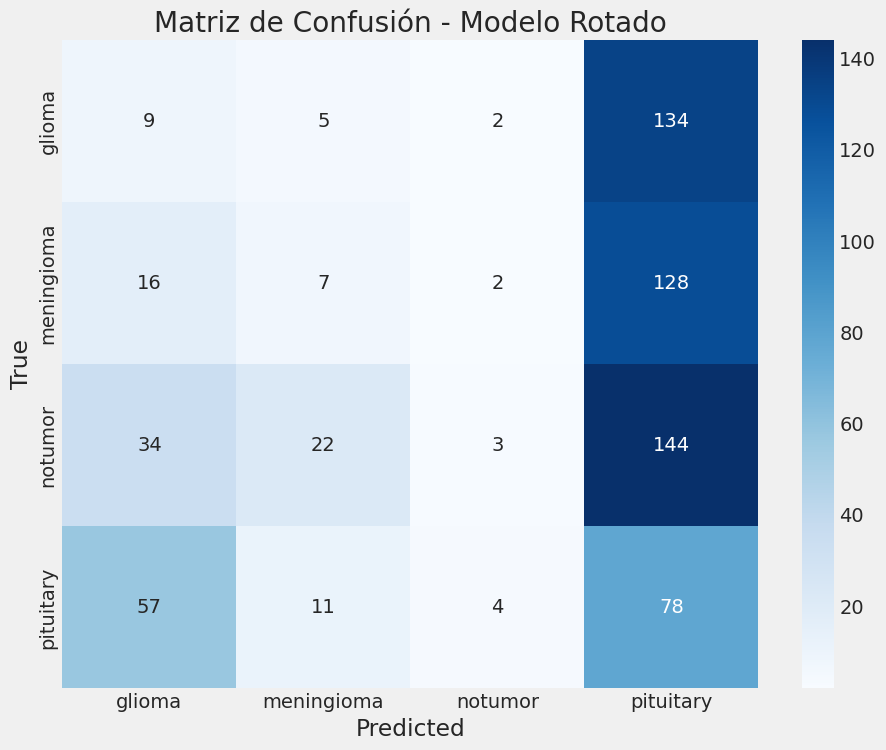

In [41]:
confusion_matrix_plot(y_pred_rotado, title='Matriz de Confusión - Modelo Rotado')


In [42]:
print(classification_report(ts_gen.classes, y_pred_rotado, target_names=ts_gen.class_indices.keys()))

              precision    recall  f1-score   support

      glioma       0.08      0.06      0.07       150
  meningioma       0.16      0.05      0.07       153
     notumor       0.27      0.01      0.03       203
   pituitary       0.16      0.52      0.25       150

    accuracy                           0.15       656
   macro avg       0.17      0.16      0.10       656
weighted avg       0.18      0.15      0.10       656



## 5.3 Modelo Rotado y Desplazado

Nuevamente se puede observar que el modelo asigna todas las imágenes de forma sobrevalorada a clases incorrectas. Esto, al igual que el modelo anterior, genera una fuerte implicancia de que este tipo de imágenes no aporta grandes beneficios al modelo con traslados y rotaciones, dado que es un ámbito donde la generalización no es tan importante como la especificidad.


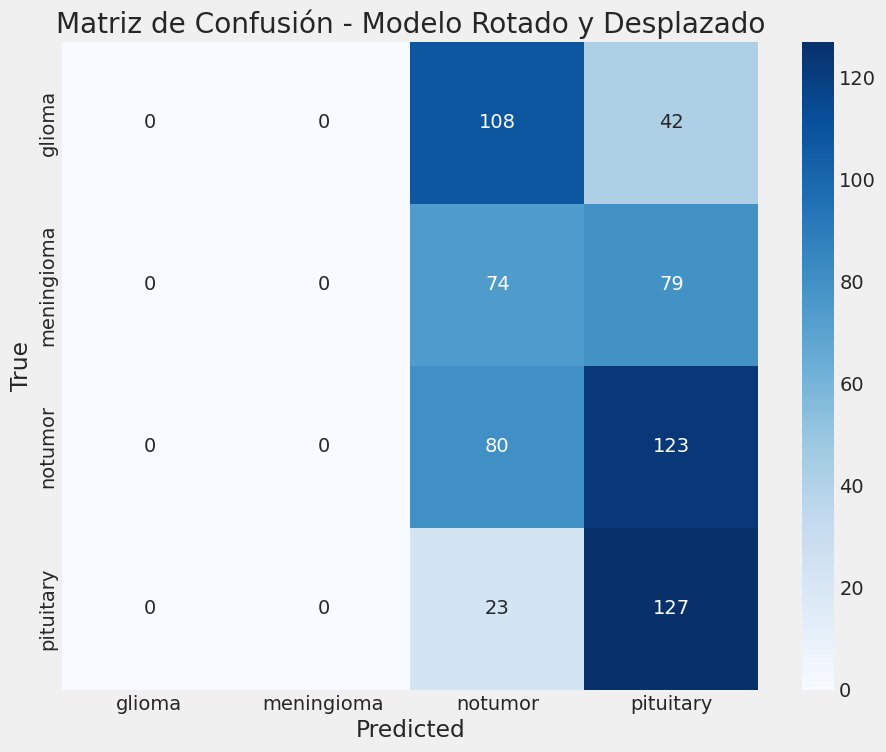

In [43]:
confusion_matrix_plot(y_pred_rotado_shifted, title='Matriz de Confusión - Modelo Rotado y Desplazado')

In [44]:
print(classification_report(ts_gen.classes, y_pred_rotado_shifted, target_names=ts_gen.class_indices.keys()))

              precision    recall  f1-score   support

      glioma       0.00      0.00      0.00       150
  meningioma       0.00      0.00      0.00       153
     notumor       0.28      0.39      0.33       203
   pituitary       0.34      0.85      0.49       150

    accuracy                           0.32       656
   macro avg       0.16      0.31      0.20       656
weighted avg       0.17      0.32      0.21       656

